## 1. Load Data

In [1]:
# Load iris dataset
from sklearn import datasets
import pandas as pd

dataset = datasets.load_iris()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [2]:
import numpy as np

x = dataset.data
y = dataset.target

# Hanya gunakan binary class (0, 1)
indexes = np.array([i for (i, s) in enumerate(y) if (s == 0 or s == 1)])
x = x[indexes]
y = 2 * y[indexes] - 1

## 2. Preprocessing
- EDA (analisis statistik, outlier, dll)

In [3]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

x = MinMaxScaler().fit_transform(x)

In [4]:
# Split train-test set (80:20)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 3. QNN Model

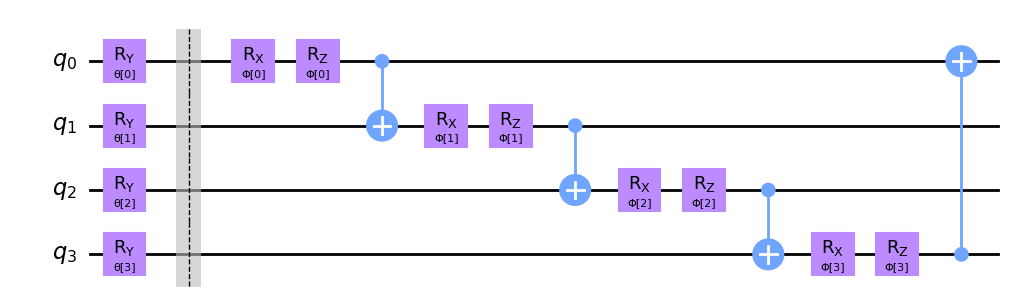

In [5]:
# Arsitektur sirkuit kuantum
import matplotlib.pyplot as plt
import qiskit
from qiskit.circuit import QuantumCircuit, ParameterVector

# Parameter sirkuit
num_qubits = x_train.shape[1]
theta      = ParameterVector('θ', num_qubits)
phi        = ParameterVector('Φ', num_qubits)
circuit    = QuantumCircuit(num_qubits)

# Encoding
for i in range(num_qubits):
  circuit.ry(theta[i], i)

circuit.barrier()

# Ansatz
for i in range(num_qubits - 1):
  circuit.rx(phi[i], i)
  circuit.rz(phi[i], i)
  circuit.cx(i, i + 1)
circuit.rx(phi[num_qubits - 1], num_qubits - 1)
circuit.rz(phi[num_qubits - 1], num_qubits - 1)
circuit.cx(3, 0)

# Plot sirkuit
circuit.draw(output='mpl', style='clifford')

In [11]:
# Kurva pembelajaran
import time
from IPython.display import clear_output

objective_func_vals = []
def callback_graph(weights, obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

In [12]:
# Classifier
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp, StateFn
from qiskit.algorithms.optimizers import COBYLA, ADAM, QNSPSA, AQGD
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

simulator        = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(simulator)
observable       = PauliSumOp.from_list([("XYZX", 1.0)])
optimizer        = COBYLA(maxiter=100)

qnn_expectation  = StateFn(observable, is_measurement=True) @ StateFn(circuit)
estimator_qnn    = EstimatorQNN(
    circuit=circuit,
    observables=observable,
    input_params=theta,
    weight_params=phi
)
qnn = NeuralNetworkClassifier(
    estimator_qnn, optimizer=optimizer, loss='squared_error', callback=callback_graph
)

C:\Users\hafid\AppData\Local\Temp\ipykernel_19828\1261292669.py:11: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(simulator)
C:\Users\hafid\AppData\Local\Temp\ipykernel_19828\1261292669.py:15: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qnn_expectation  = StateFn(observable, is_measurement=True) @ StateFn(circuit)
C:\Users\hafid\AppData\Local\Temp\ipykernel_19828\1261292669.py:15: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For co

## 4. Training

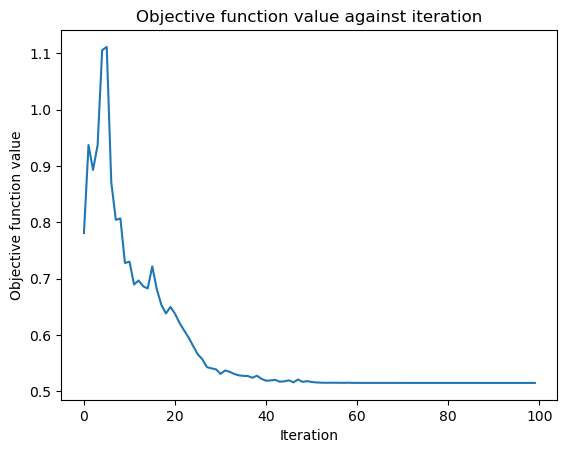

Training time: 76 seconds


In [13]:
start = time.time()
qnn.fit(x_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

## 5. Evaluation

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import classification_report

y_pred_train = qnn.predict(x_train)
y_pred_test  = qnn.predict(x_test)

print("TRAINING:")
print(classification_report(y_train, y_pred_train))
print("TESTING:")
print(classification_report(y_test, y_pred_test))

TRAINING:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        42

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

TESTING:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



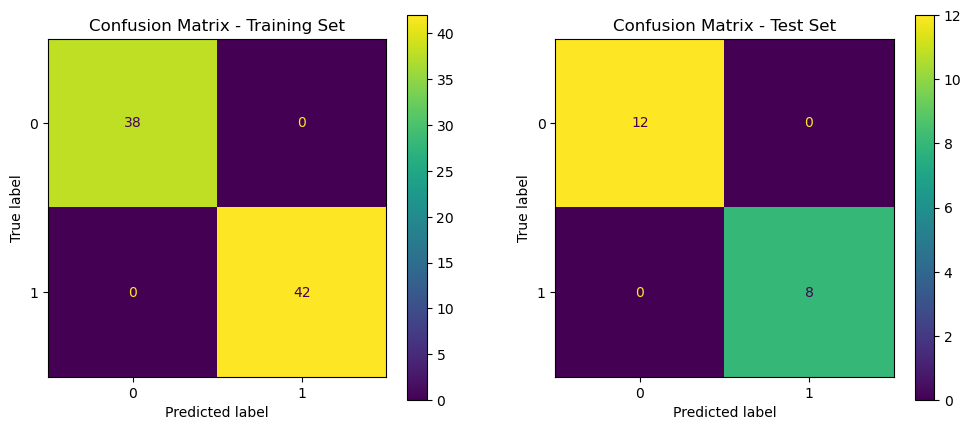

In [15]:
# Confusion matrix
cm_tr   = confusion_matrix(y_train, y_pred_train)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
cm_ts   = confusion_matrix(y_test, y_pred_test)
disp_ts = ConfusionMatrixDisplay(confusion_matrix=cm_ts)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
disp_tr.plot(ax=ax[0])
ax[0].set_title("Confusion Matrix - Training Set")
disp_ts.plot(ax=ax[1])
ax[1].set_title("Confusion Matrix - Test Set")
plt.show()

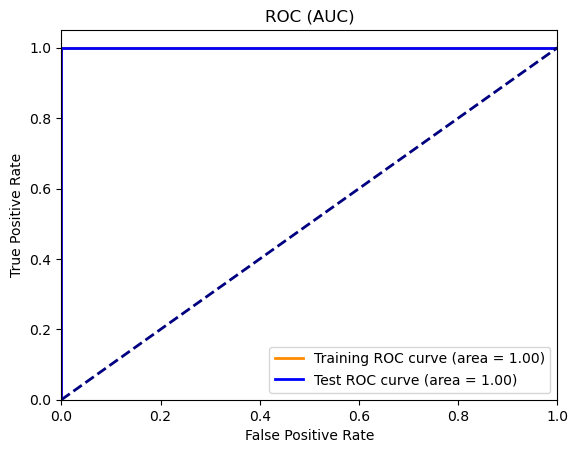

In [16]:
# Kurva ROC (AUC)
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_pred_train)
roc_auc_tr        = auc(fpr_tr, tpr_tr)
fpr_ts, tpr_ts, _ = roc_curve(y_test, y_pred_test)
roc_auc_ts        = auc(fpr_ts, tpr_ts)

plt.figure()
plt.plot(fpr_tr, tpr_tr, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_tr)
plt.plot(fpr_ts, tpr_ts, color='blue', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_ts)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (AUC)')
plt.legend(loc='lower right')
plt.show()

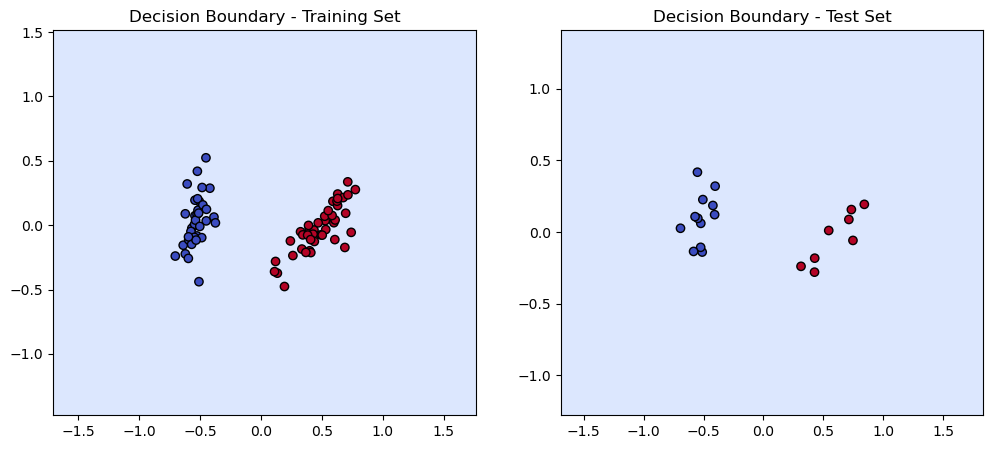

In [17]:
# Decision boundary
from sklearn.decomposition import PCA

def plot_decision_boundary(qnn, x, y, ax, title):
  x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                       np.arange(y_min, y_max, 0.01))
  mesh_points = np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], 2))]
  Z = qnn.predict(mesh_points)
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
  ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=1.5)
  ax.scatter(x[:, 0], x[:, 1], c=y, edgecolor='k', cmap='coolwarm')
  ax.set_title(title)

pca         = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca  = pca.transform(x_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(qnn, x_train_pca, y_train, ax[0], 'Decision Boundary - Training Set')
plot_decision_boundary(qnn, x_test_pca, y_test, ax[1], 'Decision Boundary - Test Set')
plt.show()